## Classification

In the last lesson, we trained our neural network on a regression task. The network predicted a number, `tmax_tomorrow`, that can take on any value.  Regression in this case refers to the output of the model, not to linear regression (it's confusing, I know).

We can also train our model on a classification task.  In a classification task, we want the network to predict which category something belongs to.  In our example, we're going to try to predict if an object detected by a telescope is a star, a galaxy, or a quasar.

We could do this with regression, and have our output be `1`, `2`, or `3` to indicate a star, a galaxy, or a quasar.  There are issues with this, though:

- In the forward pass of a neural network, we multiply by the weights to get the output.  Let's say we predict a `1`, but we actually should have predicted a `2`.  We would need to increase the weights.  But a galaxy isn't twice as large as a star.  So the mapping doesn't make sense in the context of the input data.
- We can get an intermediate value like `1.5` as a prediction, which is hard to interpret.  We'd ideally want percentages indicating the chance that an example is each of the classes.
- The network can output values below `1` or above `3`.

Classification allows us to solve this problem - it outputs the probability that an example belongs to each of the classes (star, galaxy, or quasar).  To start with, we'll work with binary classification, where we're predicting a `1` if an example is a star, and a `0` otherwise.

In classification, most of the neural network works the same - the two main things that change are the activation function and the loss function.  First, the activation function.

## Sigmoid activation

In the previous lesson, we didn't apply an activation function to the output of our network - we just output the last layer directly.  But in a binary classification problem, we want to predict either `0` or `1`.  A neural network can output values outside this range, so we need to constrain them.

We can do this using the sigmoid function, which will ensure all outputs are inside the range `0` to `1`.  Mathematically, the sigmoid function is $\sigma=\frac{1}{1 + e^{-x}}$.  $e$ is a special number is math with a value around `2.71`, with the property that the natural log of $e$ equals `1`.

Raising the number $e$ to the power $-x$ will result in a very small number when $x$ is high.  This is because a negative exponent is the product of fractions, like $3 ^ {-2}$ is equal to $1/3 * 1/3$.  When $x$ is large, the sigmoid will output a number very close to $1$, because the denominator will be close to $1$.

Raising the number $e$ to the power $-x$ when x is a negative number will make the value of $e^{-x}$ very large.  The negative sign in the sigmoid equation will undo the negative sign on $x$.  This will make the denominator very large, and push the sigmoid close to `0`.

You can see an example here:

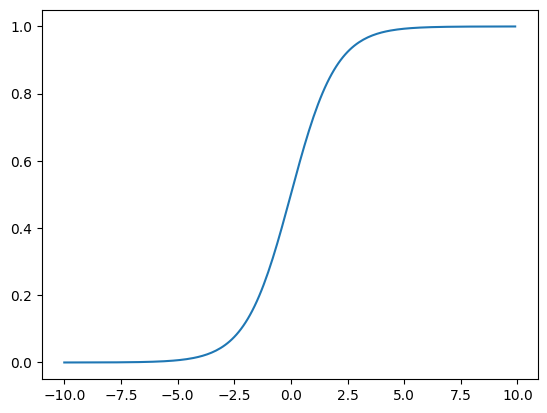

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create an array of numbers from -10 to 10
nn_outputs = np.arange(-10,10,.1)
# Define the sigmoid function
sigmoid = lambda x: 1 / (1 + np.exp(-x))

plt.plot(nn_outputs, sigmoid(nn_outputs))

We use the sigmoid activation function on the output of a neural network that does binary classification.  The sigmoid will output the probability that the example belongs to a given class.  For example, if we code a star as `1`, and everything else as a `0`, the output of the sigmoid activation tells us the probability that an example is a star.  The sigmoid output might be `.51`, corresponding to a 51% probability.

## Negative Log Likelihood

Because the range of values is so small, mean squared error isn't the best loss function.  If the actual target is a `1`, and we predict a `.5`, mean squared error will only be `.25`.  Here is how mean squared error looks with binary classification:

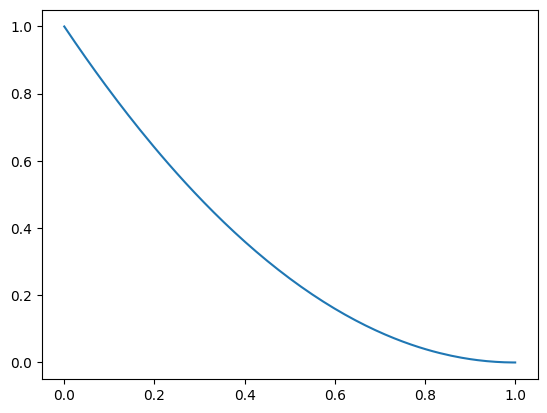

In [34]:
mse = lambda pred, actual: (actual - pred) ** 2
output_probs = sigmoid(nn_outputs)

plt.plot(output_probs, mse(output_probs, 1))

As you can see, mean squared error only ranges between `0` and `1`.  This can make it hard for the network to penalize incorrect guesses and adjust the weights properly.  We instead want a function that will penalize incorrect predictions much more than predictions that are close to the actual value.

We can instead use the negative log likelihood, which is defined as $NLL = -(y * log(\hat{y}) + (1-y) * (1-\hat{y}))$.  Since $y$ is always `0` or `1`, one half of the equation will always be `0`.  Let's say $y$ is `1`, and $\hat{y}$ is `.7`.

$$NLL = -(1 * log(.7) + (1-1) * (1-.7))$$
$$NLL = -(1 * log(.7) + 0 * (1-.7))$$
$$NLL = -(1 * log(.7))$$
$$NLL = -(1 * log(.7))$$
$$NLL = .3566$$

Remember that $log .7$ means "to what power do I need to raise $e$ to get `.7`?"  To get a number between `0` and  `1` (which is what the sigmoid function outputs), you have to raise $e$ to a negative power.  The closer the number is to `1`, the lower the negative power (the further from `0`).

You then "undo" the negative with the beginning negative sign for negative log likelihood.  Let's see how negative log likelihood changes as we change our predictions.  We're assuming that the correct target is `1`:

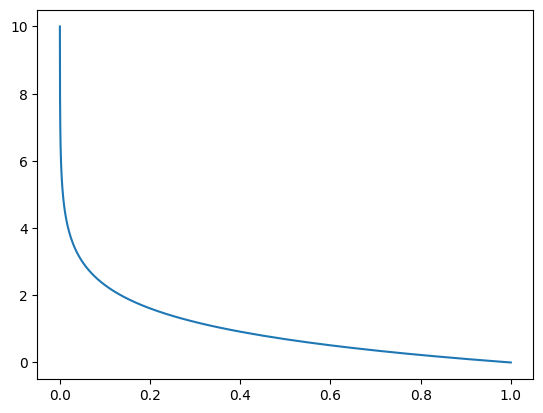

In [59]:
nll = lambda pred, actual: -(actual * np.log(pred) + (1-actual) * np.log((1-pred)))

plt.plot(output_probs, nll(output_probs, 1))

We can see that negative log likelihood gets very large as our prediction gets closer to `0`.  This loss function will penalize big errors in predictions more than mean squared error.

## Networking Training

We can now load in our data and try binary classification.

In [43]:
import os
import sys

sys.path.append(os.path.abspath("../data"))
from csv_data import SkyServerBinaryDatasetWrapper


wrapper = SkyServerBinaryDatasetWrapper("cpu")
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

In [44]:
train_x.shape

(7000, 13)

In [60]:
sys.path.append(os.path.abspath("../nnets"))
from dense import Dense

class ClassNet():
    def __init__(self):
        self.layer1 = Dense(input_size=13, output_size=25)
        self.layer2 = Dense(input_size=25, output_size=1, activation=False)
        self.last_input = None
        super().__init__()

    def forward(self, x):
        x = self.layer1.forward(x)
        x = self.layer2.forward(x)
        return x

    def backward(self, grad, lr):
        grad = self.layer2.backward(grad, lr)
        grad = self.layer1.backward(grad, lr)

The forward and backward pass will mostly work the same way they did for regression.  The main difference is in how we calculate the gradient of the loss function and backpropagate it across the sigmoid activation.

The derivative of the loss function $L$ with respect to the predicted probabilities $p$ is $\frac{\partial L}{\partial p}=\frac{p-y}{p(1-p)}$.  And the derivative across the sigmoid function of the probabilities $p$ with respect to the neural network output $z$ is $\frac{\partial p}{\partial z}=p(1-p)$.  If we want to compute the partial derivative of the loss $L$ with respect to the neural network output $z$, we multiply the two by the chain rule:

$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial p} * \frac{\partial p}{\partial z}$$
$$\frac{\partial L}{\partial z} = \frac{p-y}{p(1-p)} * \frac{\partial p}{\partial z}=p(1-p)$$
$$\frac{\partial L}{\partial z} = p - y$$

Luckily for us, the denominator multiplies out, and we're left with $p-y$, or the predicted probabilities minus the target.  So we can compute $p-y$, then pass that gradient into the neural network to do backpropagation.

In [61]:
nll_grad = lambda pred, actual: pred - actual

In [64]:
net = ClassNet()
lr = 1e-3
epochs = 50

for epoch in range(epochs):
    epoch_loss = 0
    for x, target in zip(train_x, train_y):
        x = x.reshape(1,-1)
        pred = sigmoid(net.forward(x))

        grad = nll_grad(pred, target)
        epoch_loss += nll(pred, target)[0,0]
        net.backward(grad, lr)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} train loss: {epoch_loss / len(train_x)}")

        for x, target in zip(valid_x, valid_y):
            x = x.reshape(1,-1)
            pred = sigmoid(net.forward(x))
            epoch_loss += nll(pred, target)[0,0]
        print(f"Valid loss: {epoch_loss / len(valid_x)}")

Epoch 0 train loss: 0.46290111662486866
Valid loss: 2.4898079055533557
Epoch 10 train loss: 0.21606718390113133
Valid loss: 1.2386066835766742
Epoch 20 train loss: 0.17852093704198385
Valid loss: 1.0334916612903355
Epoch 30 train loss: 0.14921610301767818
Valid loss: 0.8662254002376222
Epoch 40 train loss: 0.13005797275993652
Valid loss: 0.7544127006461103


In [ ]:
from csv_data import SkyServerDatasetWrapper


wrapper = SkyServerDatasetWrapper("cpu")
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()